# Set Up Environment

using a virtual environment  
_ensure that the numpy version is not the latest one_


**TODO:** run pip freeze after uninstalling all the dependencies that are not required

In [ ]:
import cv2
import time
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Utilities

and setting up the model

In [ ]:
# visualise the bounding box
## taken from https://github.com/google-ai-edge/mediapipe-samples/blob/main/examples/object_detection/raspberry_pi/utils.py

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red

def visualize(
    image,
    detection_result
) -> np.ndarray:
    """Draws bounding boxes on the input image and return it.
    Args:
        image: The input RGB image.
        detection_result: The list of all "Detection" entities to be visualize.
    Returns:
        Image with bounding boxes.
    """
    for detection in detection_result.detections:
        # Draw bounding_box
        bbox = detection.bounding_box
        start_point = bbox.origin_x, bbox.origin_y
        end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
        cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 2)

        # Draw label and score
        category = detection.categories[0]
        category_name = category.category_name

        # print(category_name)

        probability = round(category.score, 2)
        result_text = category_name + ' (' + str(probability) + ')'
        text_location = (MARGIN + bbox.origin_x,
                        MARGIN + ROW_SIZE + bbox.origin_y)
        cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                    FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

    return image

In [ ]:
base_options = python.BaseOptions(
    model_asset_path="models/ssd_mobilenet_v2.tflite"
)
options = vision.ObjectDetectorOptions(
    base_options=base_options,
    running_mode=vision.RunningMode.IMAGE,
    max_results=5,
    score_threshold=0.3,
)
detector = vision.ObjectDetector.create_from_options(options)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


# Testing the model

In [ ]:
visualize_file = "person_id.jpg"

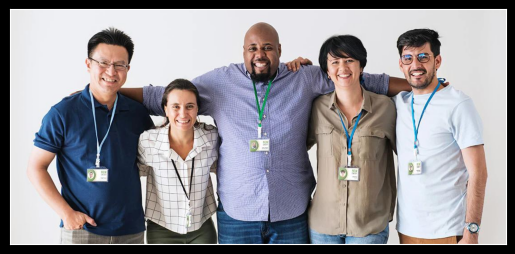

In [ ]:
img = cv2.imread(visualize_file, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([]), plt.yticks([]);

91.380 ms of inference time


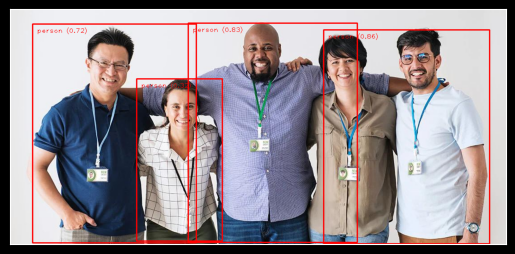

In [ ]:
# from PIL import Image
# Image.open("watch.png").resize((1200, 600)).save("watch.jpg", "jpeg")

images = ["table.jpg", "watch.jpg", "person_id.jpg"]

start_time = time.time()

for file in images:
    image = mp.Image.create_from_file(file)
    detection_result = detector.detect(image)

total_time = time.time() - start_time

print(f"{((total_time * 1000) / len(images)):.3f} ms of inference time")

image_copy = np.copy(mp.Image.create_from_file(visualize_file).numpy_view())
annotated_image = visualize(image_copy, detection_result)
plt.imshow(annotated_image)
plt.xticks([]), plt.yticks([]);

# Testing Video Feed


In [ ]:
import io
from PIL import Image
from IPython.display import display, clear_output

# video file

cap = cv2.VideoCapture("person_id.webm")

show_annotated_frames = True

while cap.isOpened():
    is_frame_correct, frame_cv = cap.read()

    if not is_frame_correct:
        print("Can't receive frame (stream ended?), exiting...")
        break
    
    frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_cv)
    detection_result = detector.detect(frame)
    
    if show_annotated_frames:
        annotated_image = visualize(np.copy(frame.numpy_view()), detection_result)
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.imshow(annotated_image)
        ax.set_xticks([]); ax.set_yticks([])
        
        buf = io.BytesIO()
        fig.savefig(buf); buf.seek(0)
        annotated_frame = Image.open(buf)

        clear_output(True)
        display(annotated_frame)
        

    if cv2.waitKey(1) == ord('q'):
        break
    elif cv2.waitKey(1) == ord('s'):
        show_annotated_frames = not show_annotated_frames

cap.release()
cv2.destroyAllWindows()


Can't receive frame (stream ended?), exiting...
